In [1]:
import torchvision 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms   
import torch.optim as optim
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.utils.prune as prune

In [2]:
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform1 = transforms.Compose(
    [    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261)),   
    ])
trainset = torchvision.datasets.CIFAR10(root='./', train=True,download=True,transform = transform1)
indices = torch.randperm(len(trainset))[:5000]
trainset1 = torch.utils.data.Subset(trainset, indices)
modelloader = torch.utils.data.DataLoader(trainset1, shuffle=True, num_workers=2, batch_size = 100)
validset = torchvision.datasets.CIFAR10(root='./', train=True,download=True, transform = transform) 
valid = list(range(40000, 50000,1))
validset1 = torch.utils.data.Subset(validset, valid)
validloader = torch.utils.data.DataLoader(validset1, shuffle=True, num_workers=4,batch_size = 100)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 20)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



In [3]:
def test_model(model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(20):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # average test loss
    test_loss = test_loss/len(modelloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [5]:

model = resnet20()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.0001, momentum=0.9)
#for name, param in model.named_parameters():
 # print(name)
model.load_state_dict(torch.load("/notebooks/resnet5k"))
test_model(model)
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    prune.l1_unstructured(module, name='weight', amount=0.4)
    #prune.l1_unstructured(module, name='bias', amount=0.2)
  elif isinstance(module, torch.nn.Linear):
    prune.l1_unstructured(module, name='weight', amount=0.4)
    prune.l1_unstructured(module, name='bias', amount=0.4)  
test_model(model)
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    prune.remove(module, 'weight')
    #prune.l1_unstructured(module, name='bias', amount=0.2)
  elif isinstance(module, torch.nn.Linear):
    prune.remove(module, 'weight')
    prune.remove(module, 'bias')
for name, param in model.named_parameters():
    print(name, param)


Test Loss: 4.140683

Test Accuracy of airplane: 53% (534/1000)
Test Accuracy of automobile: 80% (809/1000)
Test Accuracy of  bird: 58% (584/1000)
Test Accuracy of   cat: 46% (469/1000)
Test Accuracy of  deer: 55% (559/1000)
Test Accuracy of   dog: 76% (769/1000)
Test Accuracy of  frog: 79% (790/1000)
Test Accuracy of horse: 72% (728/1000)
Test Accuracy of  ship: 83% (839/1000)
Test Accuracy of truck: 89% (890/1000)

Test Accuracy (Overall): 69% (6971/10000)
Test Loss: 9.147370

Test Accuracy of airplane: 23% (230/1000)
Test Accuracy of automobile: 37% (370/1000)
Test Accuracy of  bird: 23% (238/1000)
Test Accuracy of   cat: 47% (476/1000)
Test Accuracy of  deer: 25% (256/1000)
Test Accuracy of   dog: 85% (856/1000)
Test Accuracy of  frog: 68% (687/1000)
Test Accuracy of horse: 24% (246/1000)
Test Accuracy of  ship: 86% (865/1000)
Test Accuracy of truck: 89% (895/1000)

Test Accuracy (Overall): 51% (5119/10000)
conv1.weight Parameter containing:
tensor([[[[ 0.7517,  0.6212, -0.0000],
  

In [4]:
def get_params(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

In [11]:
#matrix = np.array([])
params_all = []
count = 1
avg = 0 
for i in range(10): 
    params_trial = []
    print("##########################################################")
    print("#########################################################")
    print("trial: " + str(i))
    indices = torch.randperm(len(trainset))[:25000]
    print(indices)
    trainset1 = torch.utils.data.Subset(trainset, indices)
    modelloader = torch.utils.data.DataLoader(trainset1, shuffle=True, num_workers=2, batch_size = 100)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 20)
    #model pretrained by resnet
    #model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
    model = resnet20()
    model.load_state_dict(torch.load("/notebooks/resnet5k"))
    model.to(device) 
    #print(get_n_params(model))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)
    ##########
    #prune model by removing 0.2 of least
    ##########
    """
    for name, module in model.named_modules():
      if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.7)
        #prune.l1_unstructured(module, name='bias', amount=0.2)
      elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.7)
        prune.l1_unstructured(module, name='bias', amount=0.7) 
    test_model(model)
    """
  ################
  #training model
  ####################
    train_losslist = []
    n_epochs = [*range(50)]
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in n_epochs:
    # keep track of training and validation loss
        train_loss = 0.0
        train_loss1 = 0.0
        valid_loss = 0.0   
    ###################
    # train the model #
    ###################
        model.train()
    #model1.train()
        class_correct1 = list(0. for i in range(10))
        class_total1 = list(0. for i in range(10))
        for data, target in modelloader:
        # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
            optimizer.zero_grad()
        #optimizer1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
        #output1 = model1(data)
        # calculate the batch loss
            loss = criterion(output, target)
        #loss1 = criterion1(output1,target)
        # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, norm_type=2)
        #loss1.backward()
        # perform a single optimization step (parameter update)
            optimizer.step()
        #exp_lr_scheduler.step()
        #optimizer1.step()
        # update training loss
            train_loss += loss.item()*data.size(0)
        #train_loss1 += loss1.item()*data.size(0)
            _, pred = torch.max(output, 1)    
        # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
            for i in range(100):
                label = target.data[i]
                class_correct1[label] += correct[i].item()
                class_total1[label] += 1
    ######################    
    # validate the model #
    ######################
        model.eval()
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data, target in validloader:
            # move tensors to GPU if CUDA is available
            #if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(100):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
            # calculate average losses
        valid_loss = valid_loss/len(validloader.dataset)
        train_loss = train_loss/len(modelloader.dataset)
        train_losslist.append(train_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
        print('Training Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct1) / np.sum(class_total1),
        np.sum(class_correct1), np.sum(class_total1)))
        print('Validation Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
        if epoch == 0:
            params_trial = get_params(model).cpu().detach().numpy()
           # print(np.shape(params_trial))
            params_trial = np.reshape(params_trial,(1,-1))
        else:
            temp =get_params(model).cpu().detach().numpy()
            temp = np.reshape(temp,(1,-1))
            params_trial = np.append(params_trial, temp, axis = 0)
     #   print(np.shape(params_trial))
    ########################
    # testing model #
    ######################### 
    """
    for name, module in model.named_modules():
      if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
        #prune.l1_unstructured(module, name='bias', amount=0.2)
      elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.2)
        prune.l1_unstructured(module, name='bias', amount=0.2) 
    """
    """
    for name, module in model.named_modules():
      if isinstance(module, torch.nn.Conv2d):
        #prune.l1_unstructured(module, name='weight', amount=0.4)
        prune.remove(module, 'weight')
      elif isinstance(module, torch.nn.Linear):
       #prune.l1_unstructured(module, name='weight', amount=0.4)
       # prune.l1_unstructured(module, name='bias', amount=0.4)
        prune.remove(module, 'weight')
        prune.remove(module, 'bias')
    """
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(20):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # average test loss
    test_loss = test_loss/len(modelloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    avg += (100. * np.sum(class_correct) / np.sum(class_total))
    """
    arr = np.array([])
    for name, param in model.named_parameters():
        temp = param.cpu().detach().numpy()
        bruh = temp.flatten()
        arr =np.concatenate((arr,bruh),axis = 0)
    arr =np.reshape(arr, (1,-1))

    print(arr.shape)
    if matrix.size == 0:
        matrix = arr
    else: 
        matrix = np.append(matrix, arr, axis = 0)
    print(count)
    torch.save(model.state_dict(), "test"+str(count))
    count = count +1
    """
    if params_all == []:
        params_all = params_trial
        params_all = np.reshape(params_all,(1, params_all.shape[0], params_all.shape[1]))  
    else:
        params_trial = np.reshape(params_trial,(1, params_trial.shape[0], params_trial.shape[1]))
        params_all = np.append(params_all,params_trial, axis = 0)
  #  print(np.shape(params_all))
   # params_all.append(params_trial)
print(avg/10)

##########################################################
#########################################################
trial: 0
tensor([ 1546,  2515, 33064,  ..., 30894,  7113,  6395])
Epoch: 0 	Training Loss: 1.200565 	Validation Loss: 1.049041
Training Accuracy (Overall): 74% (18686/25000)
Validation Accuracy (Overall): 77% (7704/10000)
Epoch: 1 	Training Loss: 0.830751 	Validation Loss: 0.756604
Training Accuracy (Overall): 76% (19205/25000)
Validation Accuracy (Overall): 78% (7824/10000)
Epoch: 2 	Training Loss: 0.682459 	Validation Loss: 0.647191
Training Accuracy (Overall): 78% (19546/25000)
Validation Accuracy (Overall): 79% (7961/10000)
Epoch: 3 	Training Loss: 0.630958 	Validation Loss: 0.598232
Training Accuracy (Overall): 79% (19754/25000)
Validation Accuracy (Overall): 80% (8072/10000)
Epoch: 4 	Training Loss: 0.596431 	Validation Loss: 0.577510
Training Accuracy (Overall): 79% (19936/25000)
Validation Accuracy (Overall): 81% (8109/10000)
Epoch: 5 	Training Loss: 0.569912 	Va

/tmp/ipykernel_32/1429271593.py:215: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if params_all == []:


Epoch: 0 	Training Loss: 1.196212 	Validation Loss: 1.073666
Training Accuracy (Overall): 74% (18677/25000)
Validation Accuracy (Overall): 76% (7669/10000)
Epoch: 1 	Training Loss: 0.861051 	Validation Loss: 0.837008
Training Accuracy (Overall): 76% (19014/25000)
Validation Accuracy (Overall): 77% (7731/10000)
Epoch: 2 	Training Loss: 0.708338 	Validation Loss: 0.659438
Training Accuracy (Overall): 77% (19310/25000)
Validation Accuracy (Overall): 79% (7929/10000)
Epoch: 3 	Training Loss: 0.635411 	Validation Loss: 0.610263
Training Accuracy (Overall): 78% (19628/25000)
Validation Accuracy (Overall): 80% (8040/10000)
Epoch: 4 	Training Loss: 0.596084 	Validation Loss: 0.578207
Training Accuracy (Overall): 79% (19927/25000)
Validation Accuracy (Overall): 81% (8113/10000)
Epoch: 5 	Training Loss: 0.579187 	Validation Loss: 0.556874
Training Accuracy (Overall): 80% (20133/25000)
Validation Accuracy (Overall): 81% (8164/10000)
Epoch: 6 	Training Loss: 0.555501 	Validation Loss: 0.542279
Tra

In [13]:
#params_all = [torch.stack(trial) for trial in params_all]
#params_all =torch.FloatTensor(params_all)
#params_all = np.asarray(params_all)
params = torch.from_numpy(params_all)
#params = torch.stack(params_all) # Dimensions (in order) correspond to: parameters, time steps, and separarte trials
torch.save(params, "50epoch0.5clip1.pt")
#torch.save(params, f"{100}EpochsDivergence{5}Trials1.pt")

tensor(0.5833)
tensor(1.0417)
tensor(1.4429)
tensor(1.8305)
tensor(2.2076)
tensor(2.5595)
tensor(2.9114)
tensor(3.2523)
tensor(3.5853)
tensor(3.8926)
tensor(4.1904)
tensor(4.4647)
tensor(4.7434)
tensor(4.9989)
tensor(5.2456)
tensor(5.4869)
tensor(5.7013)
tensor(5.9229)
tensor(6.1303)
tensor(6.3253)
tensor(6.5080)
tensor(6.6707)
tensor(6.8243)
tensor(6.9589)
tensor(7.0989)
tensor(7.2146)
tensor(7.3327)
tensor(7.4316)
tensor(7.5153)
tensor(7.5941)
tensor(7.6648)
tensor(7.7213)
tensor(7.7924)
tensor(7.8402)
tensor(7.8795)
tensor(7.9136)
tensor(7.9324)
tensor(7.9570)
tensor(7.9760)
tensor(7.9752)
tensor(7.9758)
tensor(7.9770)
tensor(7.9823)
tensor(7.9727)
tensor(7.9551)
tensor(7.9339)
tensor(7.9177)
tensor(7.9041)
tensor(7.8728)
tensor(7.8496)


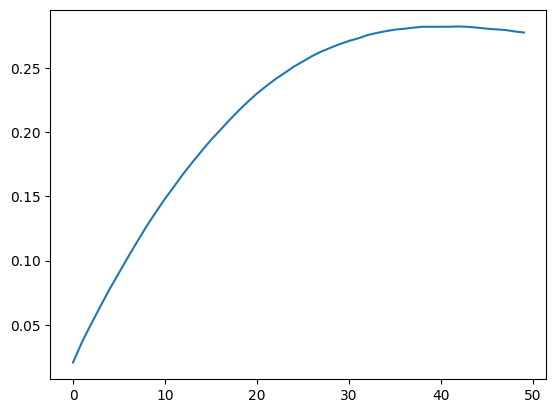

In [18]:
def get_l2_norm(data):
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    total_norm = 0.0
    for row in deviation_data:
        norm = torch.norm(row, p=2)
        norm *= norm
        total_norm += norm
   # print(total_norm)
   # print(data.size()[0])
    return total_norm / data.size()[0]
params = torch.load("50epoch0.75clip1.pt")
#print(params.size())
difference_norms = []
model_norms = []
for step in range(params.size()[1]):
    params_step = params[:, step, :]
    print(get_l2_norm(params_step))
    difference_norms.append(get_l2_norm(params_step))
    for model in range(params.size()[0]):
        model_norm = params[model, step, :]
        model_norms.append(torch.norm(model_norm, p=2))
avg_norm = sum(model_norms)/len(model_norms)
#print(avg_norm)
difference_norms_relative = [(norm/avg_norm).item() for norm in difference_norms]
plt.plot(difference_norms_relative)

In [12]:
np.save('10matrix5to25.npy', params_all)

In [5]:
def get_eig_of_differences(data):
    """
    data should be a 2-dimensional tensor whose rows are the trained parameters
    of an ML model, with one training per row. If you have a model with N
    parameters that you run M times, data should be of size (M, N). Returns a
    1-dimensional, M-element tensor whose entries are the eigenvalues (in no
    particular order) of the square matrix calculated by subtracting the mean
    of the input rows from each individual row, then right-multiplying that
    matrix by its transpose. This guarantees a M by M square matrix, which
    means that calculating the eigenvalues is surprisingly fast, even with
    reasonably large models.
    """
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    square_data = torch.matmul(deviation_data, deviation_data.transpose(0, 1))
    eig = torch.linalg.eigvals(square_data)
    return eig.real

def get_gaussian_covariance(data):
    cov = torch.cov(data.t()) 
    U, S, V = torch.linalg.svd(cov)
    T = torch.nansum(torch.sqrt(S))
    for i in range(5130):
        S[i] = math.sqrt(S[i])*T
    S = torch.diag(S)
    temp = torch.matmul(U, S)
    return torch.matmul(S,V)

def get_gaussian(data):
    cov = torch.cov(data.t()) 
    U, S, V = torch.linalg.svd(cov)
    T = torch.nansum(torch.sqrt(S))
    for i in range(5130):
        S[i] = math.sqrt(S[i])*T
    return S
    

def get_sample_covariance_eigs(data):
    cov = torch.cov(data.t()) # torch.cov expects columns, not rows, to be individual trials
    print(cov.size())
    #eig = torch.linalg.eigvals(cov)
    U, S, V = torch.linalg.svd(cov)
    return S
    #return eig.real

def l2norm(data): 
    matrix = data.numpy()
    count = 0
    total = 0
    for i in range(10):
        for j in range(i+1, 10):
            data1 = matrix[i]
            data2 = matrix[j]
           # print(np.shape(data1))
            difference = data1 -data2
           # print(type(difference))
            total += np.linalg.norm(difference)
            
            count = count+1
    print(total/count)
    print(np.linalg.norm(matrix[0]))
    print((total/count)/np.linalg.norm(matrix[0]))

def l2normgraph(data, num): 
    matrix = data
    plot1 = []
    for a in range(50):
        params_step = matrix[:, a, :]
        count = 0
        total = 0
        for i in range(num):
            for j in range(i+1, num):
                data1 = params_step[i]
                data2 = params_step[j]
               # print(np.shape(data1))
                difference = data1 -data2
               # print(type(difference))
                total += np.linalg.norm(difference)
                count = count+1
        plot1.append((total/count)/np.linalg.norm(params_step[0]))
    plt.plot(plot1)
def get_eig_of_differences_fast(data, num_eigvals=-1):
    """
    ONLY USE THIS FUNCTION AFTER RUNNING AN EXCESSIVE (>10,000) NUMBER OF TRIALS
    Acts similarly to get_eig_of_differences, except that it averages the N by N
    square matrix whose eigenvalues are calculated with its transpose, then uses
    torch.lobpcg to estimate only the num_eigvals largest eigenvalues, instead
    of calculating all of them. num_eigvals defaults to data.size()[0]
    """
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    square_data = torch.matmul(deviation_data, deviation_data.transpose(0, 1))
    square_data = (square_data+square_data.transpose(0, 1))/2
    eigvals_to_gen = data.size()[0] if num_eigvals == -1 else num_eigvals
    eig = torch.lobpcg(square_data, k=eigvals_to_gen)
    return eig[0]
def eig_estimation(data,q):
    #cov = torch.cov(data.t())
    U, S, V = torch.pca_lowrank(data, q, center=True, niter=2)
    return S
    

tensor([[[ 0.7880,  0.6509, -0.0049,  ..., -0.0245, -0.0372,  0.0204],
         [ 0.7937,  0.6634, -0.0048,  ..., -0.0239, -0.0363,  0.0199],
         [ 0.7808,  0.6511, -0.0047,  ..., -0.0233, -0.0354,  0.0194],
         ...,
         [ 0.2320,  0.2371, -0.0015,  ..., -0.0076, -0.0115,  0.0063],
         [ 0.2235,  0.2317, -0.0015,  ..., -0.0074, -0.0112,  0.0061],
         [ 0.2197,  0.2260, -0.0014,  ..., -0.0072, -0.0109,  0.0060]],

        [[ 0.7969,  0.6661, -0.0049,  ..., -0.0245, -0.0372,  0.0204],
         [ 0.7804,  0.6615, -0.0048,  ..., -0.0239, -0.0363,  0.0199],
         [ 0.7877,  0.6636, -0.0047,  ..., -0.0233, -0.0354,  0.0194],
         ...,
         [ 0.2961,  0.2682, -0.0015,  ..., -0.0076, -0.0115,  0.0063],
         [ 0.2916,  0.2616, -0.0015,  ..., -0.0074, -0.0112,  0.0061],
         [ 0.2862,  0.2526, -0.0014,  ..., -0.0072, -0.0109,  0.0060]],

        [[ 0.7809,  0.6457, -0.0049,  ..., -0.0245, -0.0372,  0.0204],
         [ 0.7779,  0.6543, -0.0048,  ..., -0

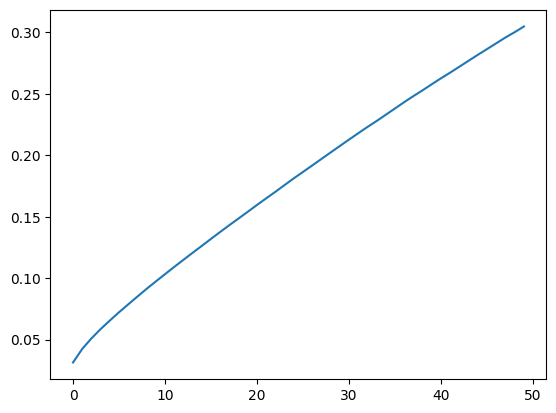

In [11]:
#matrix = np.load('/notebooks/10matrix5to25pruned70%.npy', allow_pickle = True)
#matrix = torch.load('100EpochsDivergence5Trials6.pt')
#data = matrix
params = torch.load("50epoch1.0clip1.pt")
matrix = params.numpy()

data = torch.from_numpy(matrix)
print(data)
print(f"input matrix successfully loaded. It is of size {data.size()}")
"""
eig = eig_estimation(data,10)
print(eig)
print(eig.size())
print(torch.nansum(torch.sqrt(eig)))
"""
norm1 = l2norm(data)
l2normgraph(matrix,10)

70% when changing from 5k to 25k, pruning 0.3 before, about a 17% from 67 to 84%


57% l2 norm when changing from 5k to 25k, pruning 0.2 before and 0.2 after, about a 14% from 67 to 81%

55% l2 norm from 5k to 25k, pruning 0.5 before, from 67% to 82%
sgd better than adam for me, seems to slow down after 50 epochs and less divergence, pruning yields decent results and pairwise still goes from 70% to 80%


l2 norm code produces way too crazy results for me though